- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Training only, EDA part not included.
- Image model only, tabular data not used.

Modified from HDJOJO's original notebook with SWIN Transformer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os

tqdm.pandas()

In [2]:
class Config():
    IMAGE_SIZE = 256 #384 # Sample: [224, 224]
#     BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    BACKBONE = 'swinv2_tiny_window16_256'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10 # Sample: 96
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 12 #6
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    
    DEVICE = "cuda"
    
    # Added variables
    NUM_FOLDS = 5
    VALID_FOLD = 0  # Fold of validation data
        
CONFIG = Config()

In [3]:
# Read in training data
train_df = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
train_df['file_path'] = train_df['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
train_df['jpeg_bytes'] = train_df['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
train_df.to_pickle('train.pkl') # serialize object into string form

  0%|          | 0/55489 [00:00<?, ?it/s]

### Data Filtering

In [4]:
# Sampled training set for faster training
print("Previous length:", len(train_df))
# train_df = train_df.sample(frac=0.3, random_state=42)
# print("Sampled length:", len(train_df))

Previous length: 55489


In [5]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CONFIG.NUM_FOLDS, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CONFIG.TARGET_COLUMNS):
    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, CONFIG.NUM_FOLDS + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(CONFIG.N_TARGETS)]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold
    
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,file_path,jpeg_bytes,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,/kaggle/input/planttraits2024/train_images/192...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,2,1,4,2,1,221421,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,3,2,2,2,3,332223,1.0
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,/kaggle/input/planttraits2024/train_images/196...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,5,1,5,5,2,3,515523,0.0
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,2,3,2,1,3,323213,4.0
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,3,3,5,4,4,233544,2.0


In [6]:
train = train_df[train_df["fold"] != CONFIG.VALID_FOLD]
valid = train_df[train_df["fold"] == CONFIG.VALID_FOLD] # Fold 0 is validation
train[CONFIG.TARGET_COLUMNS + ["fold"]].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean,fold
count,44391.000000,4.439100e+04,4.439100e+04,44391.000000,4.439100e+04,4.439100e+04,44391.000000
mean,0.522456,1.271709e+02,2.460040e+04,12.810444,3.096704e+03,4.938293e+05,2.499966
std,0.176001,1.237979e+04,2.582362e+06,1313.424294,2.210436e+05,1.023270e+08,1.118037
min,-2.431157,6.780000e-05,2.330000e-08,0.000097,5.500000e-07,7.690000e-08,1.000000
25%,0.410739,1.063560e+01,3.099867e-01,1.174045,5.595144e-01,2.552807e+02,1.500000
50%,0.509275,1.512003e+01,7.171231e-01,1.480130,2.529542e+00,7.258266e+02,2.000000
75%,0.622427,1.968705e+01,3.574691e+00,1.924787,1.498396e+01,2.158052e+03,3.000000
max,4.475172,1.504254e+06,2.720494e+08,159759.897700,3.106555e+07,2.155911e+10,4.000000


In [7]:
class PlantDataPreProcess:
    lower_quantile = 0.005
    upper_quantile = 0.995
    log_transform = np.log10

In [8]:
# Filter data
print("Num samples before filtering:", len(train))

for trait in CONFIG.TARGET_COLUMNS:
    lower_bound = train[trait].quantile(PlantDataPreProcess.lower_quantile)
    upper_bound = train[trait].quantile(PlantDataPreProcess.upper_quantile)
    train = train[(train[trait] >= lower_bound) & (train[trait] <= upper_bound)]
    
print("Num samples After filtering:", len(train))
train[CONFIG.TARGET_COLUMNS].describe()

Num samples before filtering: 44391
Num samples After filtering: 41797


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000
mean,0.521676,15.823053,3.207305,1.616637,42.244362,1858.297208
std,0.144273,7.598915,5.347872,0.638061,166.646792,3116.155242
min,0.176725,2.830246,0.032735,0.494166,0.006679,9.725925
25%,0.410757,10.792999,0.318085,1.186312,0.586510,267.237330
50%,0.509045,15.129038,0.714284,1.481727,2.534134,729.941079
75%,0.621267,19.511440,3.402814,1.909787,14.288664,2106.940380
max,0.957788,58.287012,32.388908,4.608223,2369.101479,29876.601410


In [9]:
## Log transforms have been integrated into model itself with selectiveExp layer

# # Log10 transformation for all traits except X4
# LOG_FEATURES = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = train[CONFIG.TARGET_COLUMNS].to_numpy()

# for skewed_trait in LOG_FEATURES:
#     y_train.loc[:, skewed_trait] = y_train[skewed_trait].apply(PlantDataPreProcess.log_transform)

# y_train.describe()

In [10]:
# Normalize to mean = 0, std dev = 1
# from sklearn.preprocessing import StandardScaler

# SCALER = StandardScaler()
# y_train = SCALER.fit_transform(y_train)

# y_train_df = pd.DataFrame(y_train, columns=CONFIG.TARGET_COLUMNS)
# y_train_df.describe()

### SWIN Transformer Data Load

In [11]:
# Previous filtering by HDJOJO
# Keep only data that is in range 0.005 to 0.985
# for column in CONFIG.TARGET_COLUMNS:
#     lower_quantile = train[column].quantile(0.005)
#     upper_quantile = train[column].quantile(0.985)  
#     train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('test.pkl')

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

  0%|          | 0/6545 [00:00<?, ?it/s]

N_TRAIN_SAMPLES: 41797 N_TEST_SAMPLES: 6545


In [12]:
print("Train len:", len(train))
print("y_train len", len(y_train))

Train len: 41797
y_train len 41797


In [13]:
# Where did values come from?
# Likely Mean/std dev for each channel - Check! (only for train though)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [448, 512],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

VALID_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]
        
        return X_sample, y_sample

train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    TRAIN_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)


valid_dataset = Dataset(
    valid['jpeg_bytes'].values,
    valid['id'].values,
    VALID_TRANSFORMS,
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    TEST_TRANSFORMS,
)

### Model with Log Adjust

In [14]:
def selective_exp(x):
    """Perform 10**x operation on all except first trait (X4)."""
    # print("Original:", x)
    if (len(x.shape) == 1):
        x_part1 = x[:1]
        x_part2 = x[1:]
    else:
        x_part1 = x[:, :1]
        x_part2 = x[:, 1:]

    # Apply exponential transformation to x_part2
    x_part2_exp = 10 ** x_part2

    # Concatenate the parts back together
    x = torch.cat((x_part1, x_part2_exp), dim=-1)
    # print("Exp:", x)
    return x

class SelectiveExp(nn.Module):
    def forward(self, x):
        return selective_exp(x)

In [15]:
class LogAdjustModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                num_classes=CONFIG.N_TARGETS,
                pretrained=True)  # Use pretrained SWIN Transformer model
        self.selectiveExp = SelectiveExp()
        
    def forward(self, inputs):
        return self.selectiveExp(self.backbone(inputs))

model = LogAdjustModel()
model = model.to(CONFIG.DEVICE)
print(model)

model.safetensors:   0%|          | 0.00/119M [00:00<?, ?B/s]

LogAdjustModel(
  (backbone): SwinTransformerV2(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerV2Stage(
        (downsample): Identity()
        (blocks): ModuleList(
          (0): SwinTransformerV2Block(
            (attn): WindowAttention(
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=3, bias=False)
              )
              (qkv): Linear(in_features=96, out_features=288, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (norm1): LayerNorm

In [16]:
# list(filter(lambda x : 'swin' in x, timm.list_models()))

In [17]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to(CONFIG.DEVICE)
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to(CONFIG.DEVICE)
LOSS = AverageMeter()

Y_MEAN = torch.tensor(y_train).mean(dim=0).to(CONFIG.DEVICE)
EPS = torch.tensor([1e-6]).to(CONFIG.DEVICE)

def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

# How is this R2 Loss?
LOSS_FN = nn.SmoothL1Loss() # r2_loss

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

metrics = {
    'epoch': [],
    'loss': [],
    'mae': [],
    'r2': [],
    'lr': [],
    'training_time': [],
    'num_params': count_parameters(model),
    'valid_r2': [],
    'valid_mae': [],
    'valid_r2_loss': [],
    'valid_sl1_loss': []
}

In [18]:
best_valid_r2 = -np.inf 

print("Start Training:")
for epoch in range(CONFIG.N_EPOCHS):
    epoch_start_time = time.time()
    MAE.reset()
    R2.reset()
    LOSS.reset()
    model.train()
    
    epoch_loss = 0
    epoch_mae = 0
    epoch_r2 = 0
        
    for step, (X_batch, y_true) in enumerate(train_dataloader):
        X_batch = X_batch.to(CONFIG.DEVICE)
        y_true = y_true.to(CONFIG.DEVICE)
        t_start = time.perf_counter_ns()
        y_pred = model(X_batch)
        loss = LOSS_FN(y_pred, y_true)
        LOSS.update(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LR_SCHEDULER.step()
        MAE.update(y_pred, y_true)
        R2.update(y_pred, y_true)
        
        epoch_loss += loss.item()
        epoch_mae += MAE.compute().item()
        epoch_r2 += R2.compute().item()
            
        if not CONFIG.IS_INTERACTIVE and (step+1) == CONFIG.N_STEPS_PER_EPOCH:
            print(
                f'EPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
            )
            
    epoch_training_time = time.time() - epoch_start_time
    
    # Validate on validation set
    VALID_ROWS = []
    model.eval()

    for X_sample_valid, valid_id in tqdm(valid_dataset):
        with torch.no_grad():
            y_pred = model(X_sample_valid.unsqueeze(0).to(CONFIG.DEVICE)).detach().cpu().numpy()

#         y_pred = SCALER.inverse_transform(y_pred).squeeze()
        y_pred = y_pred.squeeze()
        row = {'id': valid_id}

        for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
#             if k in LOG_FEATURES:
#                 row[k] = 10 ** v
#             else:
            row[k] = v

        VALID_ROWS.append(row)

    valid_predict_df = pd.DataFrame(VALID_ROWS)
    valid_y_true = torch.tensor(valid[CONFIG.TARGET_COLUMNS].to_numpy()).to(CONFIG.DEVICE)
    valid_y_pred = torch.tensor(valid_predict_df[CONFIG.TARGET_COLUMNS].to_numpy()).to(CONFIG.DEVICE)

    MAE_valid = torchmetrics.regression.MeanAbsoluteError().to(CONFIG.DEVICE)
    R2_valid = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to(CONFIG.DEVICE)
    
    with torch.no_grad():
        valid_r2 = R2_valid(valid_y_pred, valid_y_true).item()
        valid_mae = MAE_valid(valid_y_pred, valid_y_true).item()
        valid_r2_loss = r2_loss(valid_y_pred, valid_y_true).item()
        valid_sl1_loss = LOSS_FN(valid_y_pred, valid_y_true).item()
        
        
        # Log metrics for this epoch
        metrics['epoch'].append(epoch + 1)
        metrics['loss'].append(epoch_loss / len(train_dataloader))
        metrics['mae'].append(epoch_mae / len(train_dataloader))
        metrics['r2'].append(epoch_r2 / len(train_dataloader))
        metrics['lr'].append(LR_SCHEDULER.get_last_lr()[0])
        metrics['training_time'].append(epoch_training_time)
        metrics['valid_r2'].append(valid_r2)
        metrics['valid_mae'].append(valid_mae)
        metrics['valid_r2_loss'].append(valid_r2_loss)
        metrics['valid_sl1_loss'].append(valid_sl1_loss)
        
        # Save the model if validation R2 improves
        if valid_r2 > best_valid_r2:
            best_valid_r2 = valid_r2
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved Best Model at Epoch {epoch + 1} with R2: {valid_r2:.4f}')

# Save metrics to a file
import json
with open('metrics3.json', 'w') as f:
    json.dump(metrics, f)

Start Training:
EPOCH 01, 4179/4179 | loss: 261.4371, mae: 261.8166, r2: -0.2418, step: 0.157s, lr: 9.40e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 1 with R2: -0.0228
EPOCH 02, 4179/4179 | loss: 242.1840, mae: 242.5552, r2: 0.0294, step: 0.157s, lr: 9.87e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 2 with R2: 0.0084
EPOCH 03, 4179/4179 | loss: 236.9751, mae: 237.3440, r2: 0.0397, step: 0.158s, lr: 9.34e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 3 with R2: 0.0130
EPOCH 04, 4179/4179 | loss: 231.6748, mae: 232.0431, r2: 0.0662, step: 0.158s, lr: 8.45e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

EPOCH 05, 4179/4179 | loss: 226.1549, mae: 226.5235, r2: 0.0795, step: 0.157s, lr: 7.27e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 5 with R2: 0.0146
EPOCH 06, 4179/4179 | loss: 220.1531, mae: 220.5196, r2: 0.1063, step: 0.157s, lr: 5.91e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

EPOCH 07, 4179/4179 | loss: 213.1056, mae: 213.4704, r2: 0.1255, step: 0.158s, lr: 4.48e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 7 with R2: 0.0172
EPOCH 08, 4179/4179 | loss: 204.6061, mae: 204.9715, r2: 0.1369, step: 0.158s, lr: 3.09e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

EPOCH 09, 4179/4179 | loss: 194.8591, mae: 195.2252, r2: 0.1557, step: 0.158s, lr: 1.87e-05


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 9 with R2: 0.0176
EPOCH 10, 4179/4179 | loss: 184.3342, mae: 184.6986, r2: 0.1703, step: 0.158s, lr: 9.14e-06


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 10 with R2: 0.0184
EPOCH 11, 4179/4179 | loss: 176.3546, mae: 176.7193, r2: 0.1846, step: 0.157s, lr: 3.08e-06


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 11 with R2: 0.0188
EPOCH 12, 4179/4179 | loss: 171.9529, mae: 172.3173, r2: 0.0795, step: 0.158s, lr: 1.00e-06


  0%|          | 0/11098 [00:00<?, ?it/s]

Saved Best Model at Epoch 12 with R2: 0.0188


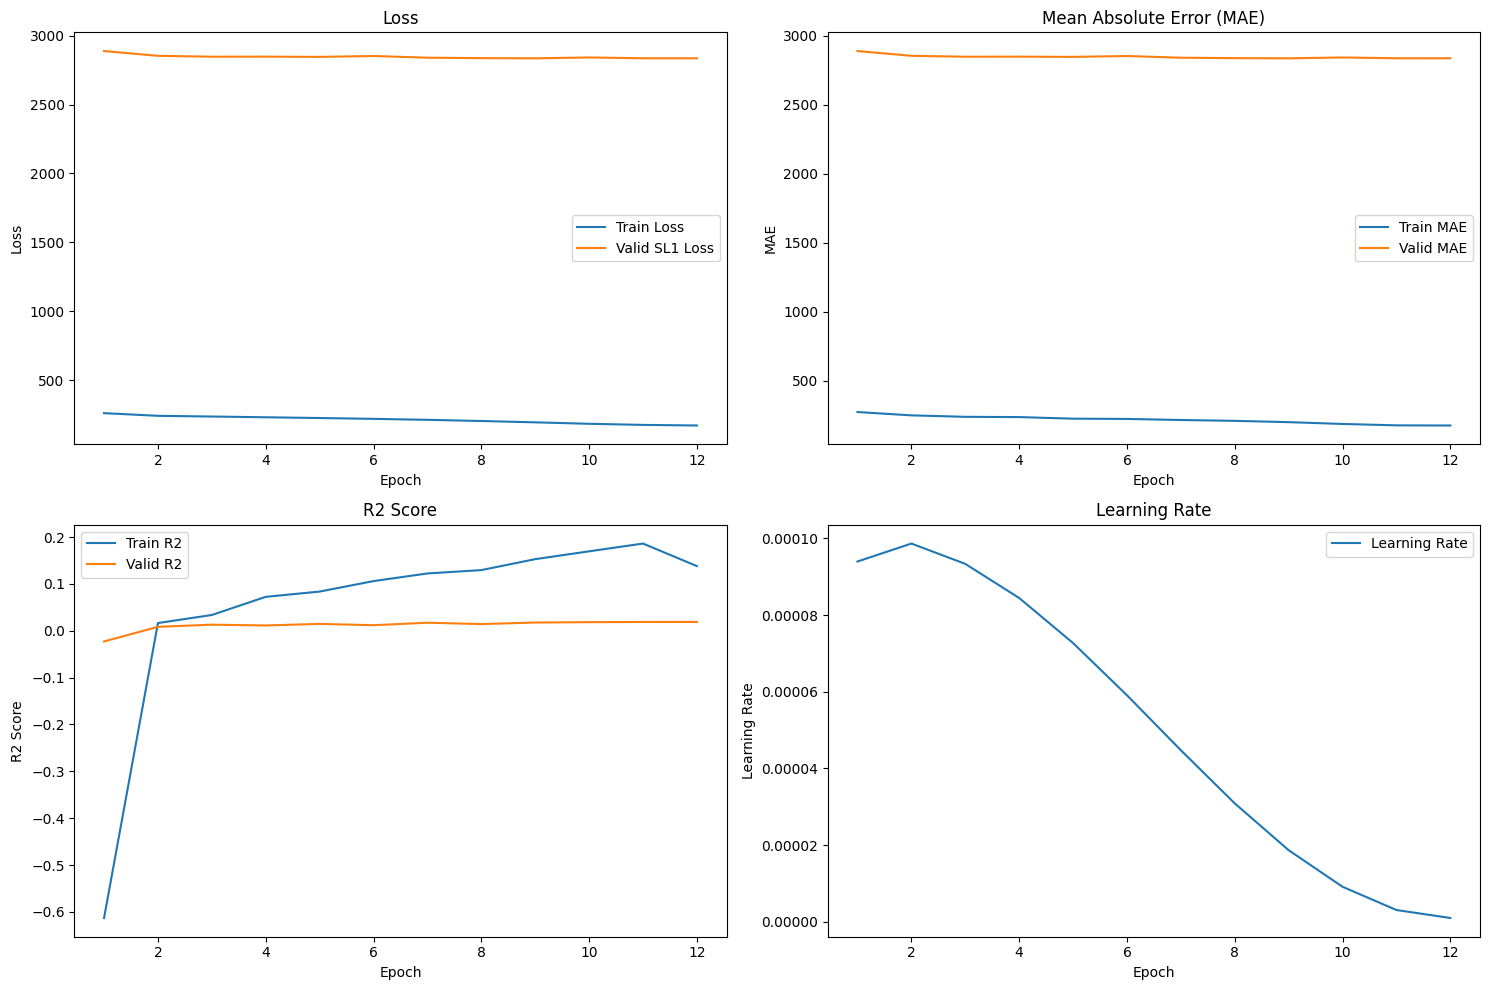

In [19]:
import json
import matplotlib.pyplot as plt

# Load the metrics
with open('metrics3.json', 'r') as f:
    metrics = json.load(f)

# Plotting training and validation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(metrics['epoch'], metrics['loss'], label='Train Loss')
axes[0, 0].plot(metrics['epoch'], metrics['valid_sl1_loss'], label='Valid SL1 Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# MAE plot
axes[0, 1].plot(metrics['epoch'], metrics['mae'], label='Train MAE')
axes[0, 1].plot(metrics['epoch'], metrics['valid_mae'], label='Valid MAE')
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# R2 plot
axes[1, 0].plot(metrics['epoch'], metrics['r2'], label='Train R2')
axes[1, 0].plot(metrics['epoch'], metrics['valid_r2'], label='Valid R2')
axes[1, 0].set_title('R2 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R2 Score')
axes[1, 0].legend()

# Learning rate plot
axes[1, 1].plot(metrics['epoch'], metrics['lr'], label='Learning Rate')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [20]:
# Validate on validation set
VALID_ROWS = []
model.eval()

for X_sample_valid, valid_id in tqdm(valid_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_valid.unsqueeze(0).to(CONFIG.DEVICE)).detach().cpu().numpy()
    
#     y_pred = SCALER.inverse_transform(y_pred).squeeze()
    y_pred = y_pred.squeeze()
    row = {'id': valid_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
#         if k in LOG_FEATURES:
#             row[k] = 10 ** v
#         else:
        row[k] = v

    VALID_ROWS.append(row)
    
valid_predict_df = pd.DataFrame(VALID_ROWS)
print(valid_predict_df.head())

  0%|          | 0/11098 [00:00<?, ?it/s]

          id   X4_mean   X11_mean   X18_mean  X50_mean   X26_mean   X3112_mean
0  196639184  0.673476   8.830725  10.935671  2.051134  13.304648  1654.150391
1  194172253  0.572717  11.226046   1.417584  1.798183   2.827538   363.944885
2  195436433  0.569528   9.160169   0.849047  1.942779   1.528255    89.828041
3  195607084  0.647731  11.561426  11.929801  1.857267  36.602272  3433.809082
4  114310764  0.508746  14.633932   0.822612  1.633543   2.426332   615.900757


In [21]:
# valid_y_true
print(valid[['id'] + CONFIG.TARGET_COLUMNS].head())
valid_y_true = torch.tensor(valid[CONFIG.TARGET_COLUMNS].to_numpy()).to(CONFIG.DEVICE)

           id   X4_mean   X11_mean  X18_mean  X50_mean   X26_mean   X3112_mean
2   196639184  0.796917   5.291251  8.552908  2.343153   0.395241  1130.096731
27  194172253  0.805731   5.046315  3.618886  1.515897  15.384261   958.310735
32  195436433  0.778597   6.673336  4.851825  3.511029  17.426103   235.341087
37  195607084  0.508277  18.149699  8.744276  1.036462   0.118370  1166.539111
40  114310764  0.564976   2.977790  1.379527  3.541963   1.087715  1173.074608


In [22]:
# Evaluate valid scores
valid_y_pred = torch.tensor(valid_predict_df[CONFIG.TARGET_COLUMNS].to_numpy()).to(CONFIG.DEVICE)

with torch.no_grad():
    # Calculate R2 Loss
    print("Validation R2 Loss (using r2_loss):", r2_loss(valid_y_pred, valid_y_true))

    # Loss function (smooth L1 loss)
    valid_loss = LOSS_FN(valid_y_pred, valid_y_true)
    print("Validation loss (Smooth L1 loss): ", valid_loss)

Validation R2 Loss (using r2_loss): tensor(0.9810, device='cuda:0', dtype=torch.float64)
Validation loss (Smooth L1 loss):  tensor(2835.7419, device='cuda:0', dtype=torch.float64)


In [23]:
# VALID_Y_MEAN = torch.tensor(y_train).mean(dim=0).to(CONFIG.DEVICE)

# def r2_loss_valid(y_pred, y_true):
#     ss_res = torch.sum((y_true - y_pred)**2, dim=0)
#     ss_total = torch.sum((y_true - VALID_Y_MEAN)**2, dim=0)
#     ss_total = torch.maximum(ss_total, torch.tensor([1e-6]))
#     r2 = torch.mean(ss_res / ss_total)
#     return r2

# print("R2 Score valid (using r2_loss_valid):", 1 - r2_loss_valid(valid_y_pred, valid_y_true))

In [24]:
# Scratch code to test R2 loss: random produced around R2 score = -92
# v_len = len(valid_y_true)
# train_y_true = torch.tensor(train[0:v_len][CONFIG.TARGET_COLUMNS].to_numpy())
# print("Train and valid R2 score:", 1 - r2_loss_valid(valid_y_true, train_y_true))

MAE_valid = torchmetrics.regression.MeanAbsoluteError().to(CONFIG.DEVICE)
R2_valid = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to(CONFIG.DEVICE)

print("Torch R2 valid:", R2_valid(valid_y_pred, valid_y_true))
print("Torch MAE valid:", MAE_valid(valid_y_pred, valid_y_true))

Torch R2 valid: tensor(0.0188, device='cuda:0')
Torch MAE valid: tensor(2836.1086, device='cuda:0')


In [25]:
# Predict on test set
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_test.unsqueeze(0).to(CONFIG.DEVICE)).detach().cpu().numpy()
    
#     y_pred = SCALER.inverse_transform(y_pred).squeeze()
    y_pred = y_pred.squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
#         if k in LOG_FEATURES:
#             row[k.replace('_mean', '')] = 10 ** v
#         else:
        row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6545 [00:00<?, ?it/s]

          id        X4        X11       X18       X50       X26        X3112
0  201238668  0.595439  11.352923  1.056308  1.788812  2.143270   287.878784
1  202310319  0.458585  16.615973  0.646348  1.452823  1.215182   404.247192
2  202604412  0.554058  11.688985  0.752634  1.839493  1.634113   219.518051
3  201353439  0.512555  20.183739  1.405626  1.289382  4.052066  1332.563477
4  195351745  0.543721  13.264250  0.614891  1.663526  1.211838   210.634842
Submit!
